# TDoA-based Target Localization and Pursuit with Autonomous Vehicles: an Model Predictive Control Approach
The main aim of the work is to implement target pursuit with two surface trackers.

## Tracker Kinematic Model
We are going to use the simplest kinematic model of the tracker with only linear and angular velocities used as the input control.
$$
\begin{bmatrix}
\dot{x} \\
\dot{y} \\
\dot{\theta} \\
\end{bmatrix}
=
\begin{bmatrix}
v \cos{\theta} \\
v \sin{\theta} \\
\omega \\
\end{bmatrix}
=
\begin{bmatrix}
\cos{\theta} & 0 \\
\sin{\theta} & 0 \\
0 & 1 \\
\end{bmatrix}
\begin{bmatrix}
v \\
\omega
\end{bmatrix}
$$
where $\mathbf{x} = [x, y, \theta]^\intercal$ are position and angle of the tracker in the inertial reference frame (the **state** vector) and $\mathbf{u} = [v, w]^\intercal$ are the input of he system (the **control** vector).

## Target Model
The tracker moves along the predefined trajectory $\mathbf{q}(t) = [q_x(t), q_y(t)]^\intercal \in \mathbb{R}^2$.
The discrete version of the tracker trajectory is
\begin{equation}
    \mathbf{q}_k = [q_{x,k}, q_{y,k}]
\end{equation}

In [1]:
# Load CasADi library
from casadi import *
import numpy as np

# ---Define the discretization constants
DeltaT = 0.1 # Sampling time, c
PredictionN = 20 # Prediction horizon (prediction steps)

# ---Define the Control limitation
VLimit     = [0.0, 3.5]             # Limitation for vehicle linear velocity, m/s
OmegaLimit = [-np.pi / 2, np.pi / 2] # Limitation for vehicle angular velocity, rad/s

# Define Weight for running cost
Q = np.diag([2, 10, 0.5]) # Weight for the state vector, Matrix 3x3
R = np.diag([0.5, 0.02]) # Weight for the control vector, Matrix 2x2

# The initial state of the tracker 1
Tracker1StateInitial = np.array([[8.0], [2.0], [np.pi/2]])
# The initial state of the tracker 2
Tracker2StateInitial = np.array([[2.0], [2.0], [0]])

# Minimal Distance between vehicles
AvoidanceRadius = 3.0

# Velocity of the target
TargetVelocity = 2.0

In [2]:
from TrackerModel import TrackerModel

# Create MPC instance for the tracker 1
tracker1 = TrackerModel(label="tracker1", prediction_horizon=PredictionN)

# Create MPC instance for the tracker 2
tracker2 = TrackerModel(label="tracker2", prediction_horizon=PredictionN)

# Create objective function for both vehicles with the same weight
objective = 0
objective = objective + tracker1.create_objective(Q, R)
objective = objective + tracker2.create_objective(Q, R)

# Define equality constraints as a python list for both vehicles
constraints = []
constraints = constraints + tracker1.create_constraints(DeltaT)
constraints = constraints + tracker2.create_constraints(DeltaT)

# Add constraints on the distance between two vehicles
for step in range(0, PredictionN + 1):
    tracker1_state = tracker1.get_state_prediction(step)
    tracker2_state = tracker2.get_state_prediction(step)
    constraints.append(AvoidanceRadius - np.sqrt((tracker1_state[0] - tracker2_state[0])**2 + (tracker1_state[1] - tracker2_state[1])**2))

# Convert Python list to CasADi Matrix (vertical concatination)
constraints = vertcat(*constraints)

In [3]:
st_size   = tracker1.state_vector.size()[0]
ctrl_size = tracker1.control_vector.size()[0]

# Reshape control variables (because we need to configure for NLP only one dimensional vector)
# But now we need to prepare the much larger vector of predictions of all states and controls within the receiving horizon
nlp_input = reshape(tracker1.get_state_prediction(), st_size * (PredictionN + 1), 1)
nlp_input = vertcat(nlp_input, reshape(tracker1.control_prediction, PredictionN * ctrl_size, 1))

nlp_input = vertcat(nlp_input, reshape(tracker2.get_state_prediction(), st_size * (PredictionN + 1), 1))
nlp_input = vertcat(nlp_input, reshape(tracker2.control_prediction, PredictionN * ctrl_size, 1))

nlp_init = np.array([])
nlp_init = vertcat(nlp_init, tracker1.state_init)
nlp_init = vertcat(nlp_init, tracker1.state_reference)
nlp_init = vertcat(nlp_init, tracker2.state_init)
nlp_init = vertcat(nlp_init, tracker2.state_reference)

# Configure the NLP solver (general view for all step within the prediction horizon)
nlp = {}
# objective function
nlp['f'] = objective
# Control inputs for NLP as column vector
nlp['x'] = nlp_input
# Initial state and reference states
nlp['p'] = nlp_init
# NLP constraints
nlp['g'] = constraints

# Define the configuration options for the solver
opts = {}
opts["print_time"] = 0
opts["verbose"] = False
opts["ipopt.max_iter"] = 100
opts["ipopt.print_level"] = 0
opts["ipopt.acceptable_tol"] = 1e-8
opts["ipopt.acceptable_obj_change_tol"] = 1e-6

# Initialize the solver
solver = nlpsol('solver', 'ipopt', nlp, opts)

# Initialize the global constraints (see constraints)
# To get equality condition we need to set upper and lower bound parameters as zeros
args = {}
# Equality constraints by kinematic model
(tracker1_lbg, tracker1_ubg) = tracker1.get_global_limits()
(tracker2_lbg, tracker2_ubg) = tracker2.get_global_limits()

args["lbg"] = np.vstack((tracker1_lbg, tracker2_lbg)) 
args["ubg"] = np.vstack((tracker1_ubg, tracker2_ubg))

# Inequality constraints by collision avoidance between vehicles
obstacle_lower_bounds = np.zeros((PredictionN + 1, 1))
obstacle_lower_bounds[:] = -inf
args["lbg"] = np.vstack((args["lbg"], obstacle_lower_bounds)) 

obstacle_upper_bounds = np.zeros((PredictionN + 1, 1))
obstacle_upper_bounds[:] = 0
args["ubg"] = np.vstack((args["ubg"], obstacle_upper_bounds)) 

# Limits for vehicles state
(tracker1_lbx, tracker1_ubx) = tracker1.get_state_limits(VLimit, OmegaLimit)
(tracker2_lbx, tracker2_ubx) = tracker2.get_state_limits(VLimit, OmegaLimit)
args["lbx"] = np.vstack((tracker1_lbx, tracker2_lbx))
args["ubx"] = np.vstack((tracker1_ubx, tracker2_ubx))

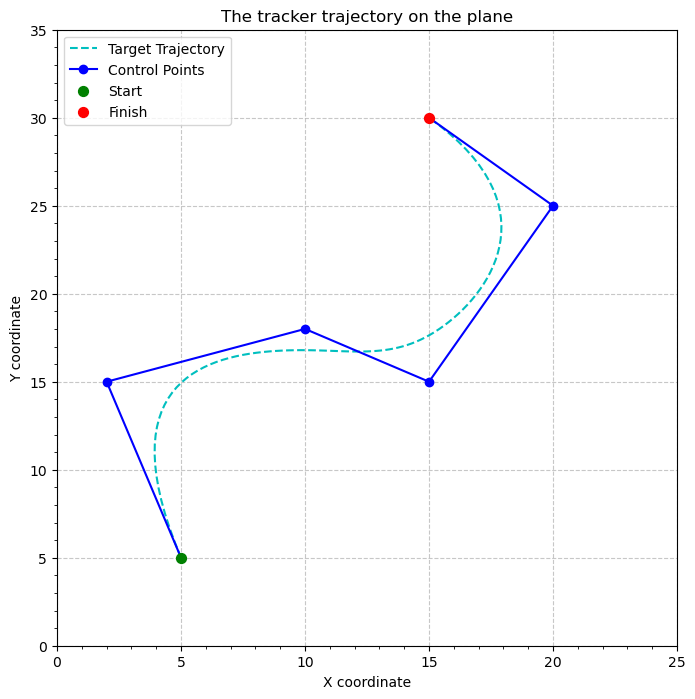

In [4]:
from TrajectoryGenerator import TrajectoryGenerator
import matplotlib.pyplot as plt

# Control points for the target trajectory 
control_points = np.array([[  5.0,  5.0],
                           [  2.0,  15.],
                           [ 10.0,  18.],
                           [ 15.,   15.],
                           [ 20.,   25.],
                           [ 15.,   30.]
                           ])

# Create trajectory instance
trajectory = TrajectoryGenerator(control_points)

# Get all list of normalized parameters to build the target trajectory
parameter_list = np.linspace(0, 1, 100)
trajectory_points = trajectory.get_trajectory_point(parameter_list)

# Display trajectory of the target
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.set_title('The tracker trajectory on the plane')
ax.set_xlabel('X coordinate')
ax.set_ylabel('Y coordinate')
ax.set_xlim(0, 25)
ax.set_ylim(0, 35)
ax.grid(True, linestyle="--", alpha=0.7)
ax.minorticks_on()

ax.plot(trajectory_points[:, 0], trajectory_points[:, 1], '--', label='Target Trajectory', color='c', zorder=2)
ax.plot(control_points[:, 0], control_points[:, 1], '-o', label='Control Points', color='b', zorder=2)
ax.scatter(trajectory_points[0, 0], trajectory_points[0, 1], marker='o', s=50, label='Start', color='g', zorder=3)
ax.scatter(trajectory_points[-1, 0], trajectory_points[-1, 1], marker='o', s=50, label='Finish', color='r', zorder=3)
ax.legend(loc='upper left')

In [5]:
def getTrajectoryPart(trajectory, parameter: float, steps: int):
    vector = []
    
    for st in range(0, steps):
        # check is this is the end of trajectory
        terminal_step = parameter > 1.0

        # Limit the trajectory parameter for predictions
        if terminal_step:
            parameter = 1.0

        # Get target coordinate
        target_point = trajectory.get_trajectory_point(parameter)

        # Calculate tangent vector at the point
        trajectory_derivative = trajectory.get_trajectory_derivative(parameter)
        target_yaw = np.arctan2(trajectory_derivative[1], trajectory_derivative[0])

        # Configure target state
        target_state = np.append(target_point, target_yaw)

        # Calculate a new parameter delta to preserve velocity constant
        parameter_delta_delta = TargetVelocity * DeltaT / np.linalg.norm(trajectory_derivative)
        parameter = parameter + parameter_delta_delta

        # Add state vector within the horizon
        vector.append(target_state)
        # Add control vector within the horizon (zero linear velocity if this is the terminal state)
        vector.append(np.array([TargetVelocity if not terminal_step else 0.0, 0.0]))
    return vector

In [6]:
import time

# We don't have any prediction, so zeros are our best guess
tracker1_control_guess = np.zeros((PredictionN, ctrl_size))
# The state on the first point will be not far of the Tracker1StateInitial
tracker1_state_guess = repmat(Tracker1StateInitial, 1, PredictionN + 1)

# We don't have any prediction, so zeros are our best guess
tracker2_control_guess = np.zeros((PredictionN, ctrl_size))
# The state on the first point will be not far of the Tracker1StateInitial
tracker2_state_guess = repmat(Tracker2StateInitial, 1, PredictionN + 1)

tracker1.init_storages()
tracker2.init_storages()

# Storage for target states
storage_target_states = []
        
# Current state of the robot. At the beginning it coincides with the x_start
tracker1_state_current = Tracker1StateInitial
tracker2_state_current = Tracker2StateInitial

# Start timer to check performance
time_start = time.process_time()

# Target trajectory parameter
parameter = 0

# Main Loop of the motion control
while parameter < 1.0:
    #----- Update target position
    # Get target coordinate
    target_point = trajectory.get_trajectory_point(parameter)

    # Calculate tangent vector at the point
    trajectory_derivative = trajectory.get_trajectory_derivative(parameter)
    target_yaw = np.arctan2(trajectory_derivative[1], trajectory_derivative[0])

    # Configure target state
    target_state = np.append(target_point, target_yaw).reshape((-1, 1))

    target_future_trajectory = getTrajectoryPart(trajectory, parameter, PredictionN)

    #----- Prepare initial vector for tracker 1
    # Upload new initial state (new each step) and the target state (for each point within the prediction horizon)
    # First part is current state
    tracker1_init = []
    tracker1_init.append(tracker1_state_current.flatten())
    tracker1_init = tracker1_init + target_future_trajectory

    # Reshape the initial vector to standard representation
    tracker1_init = np.concatenate(tracker1_init, axis=0)
    tracker1_init = tracker1_init.reshape(-1, 1)

    #----- Prepare initial vector for tracker 1
    # Upload new initial state (new each step) and the target state (for each point within the prediction horizon)
    # First part is current state
    tracker2_init = []
    tracker2_init.append(tracker2_state_current.flatten())
    tracker2_init = tracker2_init + target_future_trajectory

    # Reshape the initial vector to standard representation
    tracker2_init = np.concatenate(tracker2_init, axis=0)
    tracker2_init = tracker2_init.reshape(-1, 1)

    args["p"] = np.vstack((tracker1_init, tracker2_init))

    #----- Prepare initial guess for tracker 1 and tracker 2
    # Set initial guess for NLP
    initial_guess = np.array([])
    # Initial guess for the tracker 1
    initial_guess = vertcat(initial_guess, reshape(tracker1_state_guess, st_size * (PredictionN + 1), 1))
    initial_guess = vertcat(initial_guess, reshape(tracker1_control_guess.T, ctrl_size * PredictionN, 1))
    # Initial guess for the tracker 2
    initial_guess = vertcat(initial_guess, reshape(tracker2_state_guess, st_size * (PredictionN + 1), 1))
    initial_guess = vertcat(initial_guess, reshape(tracker2_control_guess.T, ctrl_size * PredictionN, 1))

    args["x0"] = initial_guess

    #----- Solve the OCP for both vehicles
    sol = solver(x0=args["x0"], p=args["p"],
                 lbx=args["lbx"], ubx=args["ubx"],
                 lbg=args["lbg"], ubg=args["ubg"]
                 )

    # Divide solution for two parts (for the tracker 1 and tracker 2)
    tracker1_solution = sol['x'][ :int(sol['x'].size()[0] / 2)]
    tracker2_solution = sol['x'][int(sol['x'].size()[0] / 2): ]

    # Reshape obtained contol predictions vector to matrix (2xPredictionN)
    # Extract only control predictions
    tracker1_control_predictions = reshape(tracker1_solution[st_size * (PredictionN + 1):].T, ctrl_size, PredictionN).T
    # We need only the first control value in the storage
    tracker1_control = tracker1_control_predictions[0, :]

    # Reshape obtained contol predictions vector to matrix (2xPredictionN)
    # Extract only control predictions
    tracker2_control_predictions = reshape(tracker2_solution[st_size * (PredictionN + 1):].T, ctrl_size, PredictionN).T
    # We need only the first control value in the storage
    tracker2_control = tracker2_control_predictions[0, :]

    # Extract only state predictions
    tracker1_state_predictions = reshape(tracker1_solution[:st_size * (PredictionN + 1)].T, st_size, PredictionN + 1)
    
    # Extract only state predictions
    tracker2_state_predictions = reshape(tracker2_solution[:st_size * (PredictionN + 1)].T, st_size, PredictionN + 1)

    #----- Storage data for tracker 1
    # Store the state vector on the each step of simulation
    tracker1.storage_states.append(tracker1_state_current)

    # Store predicted states in the list of 2D Matrix
    tracker1.storage_predictions.append(tracker1_state_predictions.T)

    # Store only the first control value in the storage
    tracker1.storage_control.append(tracker1_control)

    #----- Storage data for tracker 2
    # Store the state vector on the each step of simulation
    tracker2.storage_states.append(tracker2_state_current)

    # Store predicted states in the list of 2D Matrix
    tracker2.storage_predictions.append(tracker2_state_predictions.T)

    # Store only the first control value in the storage
    tracker2.storage_control.append(tracker2_control)

    # Store current target state
    storage_target_states.append(target_state)

    #----- Shift state of the tracker 1
    # Shift the time and initial position for solver
    # We propagate control actions to obtain the new state of the system at this point
    tracker1_state_current = tracker1_state_current + (DeltaT *  tracker1.kin_function(tracker1_state_current, tracker1_control.T))
    tracker1_state_current = np.array(tracker1_state_current)
    
    tracker2_state_current = tracker2_state_current + (DeltaT *  tracker2.kin_function(tracker2_state_current, tracker2_control.T))
    tracker2_state_current = np.array(tracker2_state_current)

    # Calculate a new parameter delta for target motion to preserve velocity constant
    parameter_delta = TargetVelocity * DeltaT / np.linalg.norm(trajectory_derivative)
    parameter = parameter + parameter_delta

    #----- Shift state and control guess of the tracker 1
    # We the control action predictions and state predictions as the best guess for the next control
    # Just trim the first row, because we already used it and append zero row at the end
    tracker1_control_guess = np.delete(tracker1_control_predictions, 0, axis=0)
    tracker1_control_guess = np.vstack((tracker1_control_guess, tracker1_control_predictions[-1, :]))

    tracker1_state_guess = np.delete(tracker1_state_predictions, 0, axis=1)
    tracker1_state_guess = np.hstack((tracker1_state_guess, tracker1_state_predictions[:, -1]))
    
    tracker2_control_guess = np.delete(tracker2_control_predictions, 0, axis=0)
    tracker2_control_guess = np.vstack((tracker2_control_guess, tracker2_control_predictions[-1, :]))

    tracker2_state_guess = np.delete(tracker2_state_predictions, 0, axis=1)
    tracker2_state_guess = np.hstack((tracker2_state_guess, tracker2_state_predictions[:, -1]))

# Simulation steps number
simulation_steps = len(tracker1.storage_control)

elapsed_time = time.process_time() - time_start
print(f"Overal OCP time for all steps: {elapsed_time} sec. Per step: {elapsed_time / simulation_steps}")

tracker1.convert_storages()
tracker2.convert_storages()

# Concatinate all data along the second axis (because state is the column-vector)
storage_target_states = np.concatenate(storage_target_states, axis=1)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Overal OCP time for all steps: 3.797945705000001 sec. Per step: 0.021579236960227278


KeyboardInterrupt: 

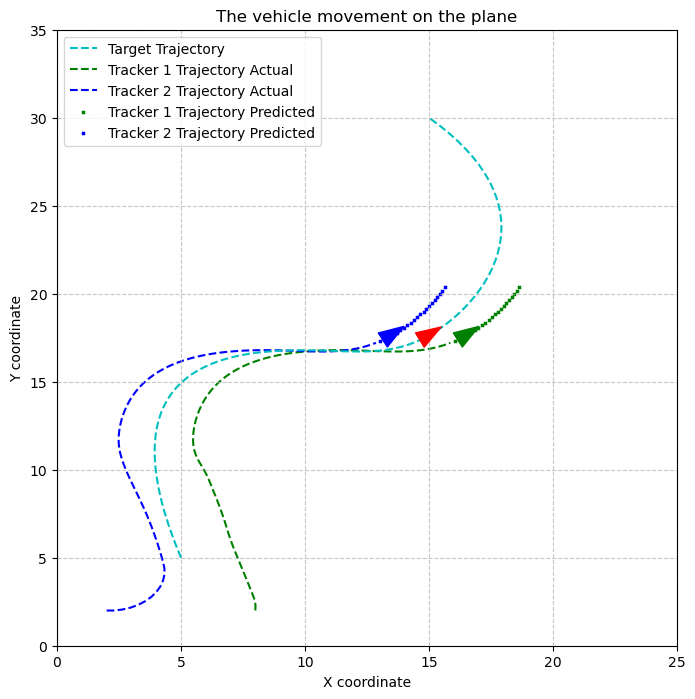

In [10]:
import matplotlib.pyplot as plt
from IPython import display
import utility as ut
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.set_title('The vehicle movement on the plane')
ax.set_xlabel('X coordinate')
ax.set_ylabel('Y coordinate')
ax.set_xlim(0, 25)
ax.set_ylim(0, 35)
ax.grid(True, linestyle="--", alpha=0.7)

# Heading Figure size
markersize = 40

# Plot the target trajectory
ax.plot(trajectory_points[:, 0], trajectory_points[:, 1], '--', label='Target Trajectory', color='c', zorder=2)

for i in range(simulation_steps):
    marker_target, scale = ut.gen_arrow_head_marker(storage_target_states[2, i])
    pointer_target = ax.scatter(storage_target_states[0, i], storage_target_states[1, i],
                                marker=marker_target, s=(markersize*scale)**2, color='red', zorder=3)

    marker_tracker, scale = ut.gen_arrow_head_marker(tracker1.storage_states[2, i])
    tracker1_pointer = ax.scatter(tracker1.storage_states[0, i], tracker1.storage_states[1, i],
                                  marker=marker_tracker, s=(markersize*scale)**2, color='green', zorder=3)

    marker_tracker, scale = ut.gen_arrow_head_marker(tracker2.storage_states[2, i])
    tracker2_pointer = ax.scatter(tracker2.storage_states[0, i], tracker2.storage_states[1, i],
                                  marker=marker_tracker, s=(markersize*scale)**2, color='blue', zorder=3)

    tracker1_trajectory = ax.plot(tracker1.storage_states[0, 0:i], tracker1.storage_states[1, 0:i], 
                                linestyle="--", linewidth=1.5, color='green', 
                                label='Tracker 1 Trajectory Actual', zorder=1)[0]
    
    tracker2_trajectory = ax.plot(tracker2.storage_states[0, 0:i], tracker2.storage_states[1, 0:i], 
                                linestyle="--", linewidth=1.5, color='blue', 
                                label='Tracker 2 Trajectory Actual', zorder=1)[0]
    
    tracker1_predict = ax.scatter(tracker1.storage_predictions[:, 0, i], tracker1.storage_predictions[:, 1, i],
                                    color='green', marker='x', s=4, label='Tracker 1 Trajectory Predicted', zorder=1)
    tracker2_predict = ax.scatter(tracker2.storage_predictions[:, 0, i], tracker2.storage_predictions[:, 1, i],
                                    color='blue', marker='x', s=4, label='Tracker 2 Trajectory Predicted', zorder=1)
    ax.legend(loc='upper left')

    # Update plot rendering
    display.clear_output(wait=True)
    display.display(fig)

    # Wait to render the current step of the trajectory
    # with 5x faster than simulation process
    fast_forward_scale = 5
    time.sleep(DeltaT / fast_forward_scale)

    # Remove pointer in order to redraw it on the next stage
    tracker1_predict.remove()
    tracker2_predict.remove()
    tracker1_trajectory.remove()
    tracker2_trajectory.remove()
    tracker1_pointer.remove()
    tracker2_pointer.remove()
    pointer_target.remove()

plt.close(fig)